# Interpretability Assignment

Language models are trained to predict tokens given other tokens. More specifically, the autoregressive Language Modelling objective is given by the following distribution:

$$
P(w_{t} \mid w_{t-1}, w_{t-2} \dots w_0)
$$

The standard Transformer-based Language Model sees tokens as the lowest granularity of language. It sees tokens as entities and predicts other tokens. These models are not given the spelling of a token explicitly.

The question we ask in this assignment is, "to what extent do the representations of words from an LM encode character information?"

"What is it about the Language Modelling objective that allows a model to deduce something about the characters of a token?"


To accomplish our purposes, we will conduct probing studies.
- design a task that relies on the spelling of a word.
- check if a thin (one layer) classifier can be trained on top of LM embeddings to do this task.
- design a control to check whether the task is too easy.

### ***REPORT AT THE END***
### Suyash Sethia
### 2021114010

In [1]:
import torch

## Initializing the model

We will be studying a pretrained RoBERTa model. Run the cell below to initialize it.

In [2]:
# loading a small model

from transformers import AutoTokenizer, AutoModel, AutoConfig

config = AutoConfig.from_pretrained("roberta-base")
model = AutoModel.from_pretrained("roberta-base", config=config)
model.eval()
model.cuda()
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Example tokenization

Any input text given to the model is first toknized. Typically this is sub-word tokenization i.e. words are broken down further.

A sub subword is the most atomic input given to a language model. For example.

In [3]:
sentence = "This is an example tokenization"
tokenizer.tokenize(sentence)

['This', 'Ġis', 'Ġan', 'Ġexample', 'Ġtoken', 'ization']

As can be seen above, the word "tokenzation" has been broken down into "token" and "ization"

There is no explicit granulairity more than this. In other words, the model __does not directly__ see letters of a word.

The Language Model is trained to predict the next token given the previous tokens. Should this give it a sense of what letters exist in that token?

## Experiment 1

Can the model do something simple like distinguish between capitalized and non-capitalized words?

In other words, we ask if there is a reliable signal in the representations from the model for us to be able to predict whether a word is capitalized or not.

### Q1.1 Make appropriate dataset

In [4]:
!git clone https://github.com/dwyl/english-words.git

Cloning into 'english-words'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 248 (delta 97), reused 83 (delta 83), pack-reused 123
Receiving objects: 100% (248/248), 27.63 MiB | 15.32 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [5]:
words_list = []
with open("english-words/words_alpha.txt") as f:
    for line in f:
        words_list.append(line.strip())


Take the word list and phrase a classification problem to check the above sub-task:

- Make a train set
- Make a validation set
- Make a test set

In [6]:
word_list_small = [word.lower() for word in words_list]
dataset = []

label = 0
import random
for i, word in enumerate(word_list_small):
    if random.random() > 0.5:
        label = 1
        word = word.capitalize()
    else:
        label = 0
    dataset.append((word, label,))

In [7]:
from sklearn.model_selection import train_test_split
# split into three
train, test = train_test_split(dataset, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [8]:
def check_train_val_test_splits(train, val, test):
    assert len(train) > 0
    assert len(val) > 0
    assert len(test) > 0
    train_set = set(train)
    val_set = set(val)
    test_set = set(test)
    assert len(train_set.intersection(val_set)) == 0
    assert len(train_set.intersection(test_set)) == 0
    assert len(val_set.intersection(test_set)) == 0
    print("All checks passed")


# pass your datasets here
check_train_val_test_splits(train, val, test)

All checks passed


In [9]:
DEVICE = "cuda"

### Get the embeddings from the model for those words

In [10]:
def get_embeddings_all_layers(model, tokenizer, data, pool_func, layer=-1,):
    embed_list = []
    for word, label in data:
        # print(word)
        inputs = tokenizer(word, return_tensors="pt").to(device=DEVICE)
        # print(inputs)
        embeddings = model(**inputs, output_hidden_states=True)
        # embeddings = torch.stack(outputs.hidden_states).squeeze()
        embeddings = embeddings.hidden_states[layer].detach().cpu().numpy()
        embeddings = pool_func(embeddings, dim=-2)
        # print(embeddings.shape)
        embed_list.append(embeddings)
    return embed_list

In [11]:
import torch
import numpy as np


# randomly chose 50% of the train data
train_small = random.sample(train, int(len(train) * 1))
test_small = random.sample(test, int(len(train) * 1))


embeds = get_embeddings_all_layers(model, tokenizer, train_small, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)
embeds_test = get_embeddings_all_layers(model, tokenizer, test_small, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)


assert embeds[0].shape[-1] == config.hidden_size


In [12]:
# concatenate the embeddings
embeds = np.concatenate(embeds, axis=0)
embeds_test = np.concatenate(embeds_test, axis=0)

In [13]:
embeds

array([[-0.04814559, -0.00889107,  0.00580206, ..., -0.00800052,
        -0.0364606 , -0.00907906],
       [-0.04940173,  0.0718441 ,  0.04654169, ..., -0.08133921,
        -0.04442363, -0.00420139],
       [ 0.01435026,  0.15853499, -0.07031671, ...,  0.03312995,
         0.05405915, -0.02210528],
       ...,
       [-0.0249346 , -0.03470769, -0.03149068, ...,  0.02671403,
        -0.07142543,  0.00729527],
       [-0.04801067,  0.13370629, -0.02804764, ...,  0.14003739,
        -0.06043186, -0.03730633],
       [-0.04994255,  0.01804607, -0.00929476, ..., -0.20751229,
        -0.08941411, -0.01974101]], dtype=float32)

### Make a classifier

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
log_regress = LogisticRegression(max_iter=1000)
log_regress.fit(embeds, [train_small[i][1] for i in range(len(train_small))])

LogisticRegression(max_iter=1000)

In [16]:
from sklearn.metrics import classification_report

In [17]:
print(classification_report([test_small[i][1] for i in range(len(test_small))], log_regress.predict(embeds_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       575
           1       0.99      0.97      0.98       609

    accuracy                           0.98      1184
   macro avg       0.98      0.98      0.98      1184
weighted avg       0.98      0.98      0.98      1184



## Extracting specific letter information from encodings

Check if the model embeddings encode information about the _first_ letter of a word.

Code up the experiment for this

- Make a balanced dataset __[4]__
- Train a classifier __[2]__
- Print a  classification report (precision and recall for all classes) __[2]__


In [18]:
import pandas as pd

df = pd.DataFrame(word_list_small, columns = ['words'])
#add column with fitst letter OF WORD AS CLASSES 1 , 2 ,3 .. 26
df['classes'] = df['words'].apply(lambda x: ord(x[0].lower()) - 96)
#convert df to list with tuples
dataset = [tuple(x) for x in df.to_numpy()]
# split into three
train, test = train_test_split(dataset, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
check_train_val_test_splits(train, val, test)

train_small = random.sample(train, int(len(train) * 1))
test_small = random.sample(test, int(len(train) * 1))

embeds = get_embeddings_all_layers(model, tokenizer, train_small, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)
embeds_test = get_embeddings_all_layers(model, tokenizer, test_small, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)

assert embeds[0].shape[-1] == config.hidden_size

embeds = np.concatenate(embeds, axis=0)
embeds_test = np.concatenate(embeds_test, axis=0)

log_regress = LogisticRegression(max_iter=1000)
log_regress.fit(embeds, [train_small[i][1] for i in range(len(train_small))])

print(classification_report([test_small[i][1] for i in range(len(test_small))], log_regress.predict(embeds_test)))




All checks passed
              precision    recall  f1-score   support

           1       0.32      0.47      0.38        83
           2       0.45      0.47      0.46        62
           3       0.45      0.57      0.50       115
           4       0.74      0.51      0.61        72
           5       0.23      0.30      0.26        50
           6       0.50      0.42      0.46        33
           7       0.36      0.32      0.34        28
           8       0.49      0.53      0.51        38
           9       0.60      0.17      0.27        35
          10       1.00      0.11      0.20         9
          11       0.75      0.30      0.43        10
          12       0.76      0.44      0.56        36
          13       0.44      0.31      0.36        52
          14       0.61      0.54      0.57        41
          15       0.30      0.14      0.19        42
          16       0.52      0.69      0.59       109
          17       0.00      0.00      0.00         2
         

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

## Do we need 'real' words?

Devise an experiment to check if the model is using semantic information to make its predictions (and not some direct notion of spelling)

- Design an experiment to make it impossible for the semantics to be used in the above task. __[4]__
- Make a dataset for it __[2]__
- Learn a classifier for it __[1]__
- Do the analysis across layers __[3]__

In [19]:
# KEEP the first letter same as the original word ans shuffle the rest of the letters
import random

def shuffle_word(word):
    word = list(word)
    fist_letter = word[0]
    rest = word[1:]
    random.shuffle(rest)
    return fist_letter + "".join(rest)

# test the function
dataset = [shuffle_word(word) for word in word_list_small]
# print(shuffle_word("hello"))


dataset_new = []
label = 0

for i, word in enumerate(dataset):
    if random.random() > 0.5:
        label = 1
        word = word.capitalize()
    else:
        label = 0
    dataset_new.append((word, label,))
print(len(dataset_new))



370105


In [20]:
# do analysis across layers by changing the layer in ebmeddings

train_small = random.sample(train, int(len(train) * 1))
test_small = random.sample(test, int(len(train) * 1))

In [21]:
import plotly.graph_objects as go


results = []
for i in range(1, 10):
  embeds = get_embeddings_all_layers(model, tokenizer, train_small, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-i)
  embeds_test = get_embeddings_all_layers(model, tokenizer, test_small, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-i)

  assert embeds[0].shape[-1] == config.hidden_size

  embeds = np.concatenate(embeds, axis=0)
  embeds_test = np.concatenate(embeds_test, axis=0)

  log_regress = LogisticRegression(max_iter=1000)
  log_regress.fit(embeds, [train_small[i][1] for i in range(len(train_small))])
  print(f"Layer number from last used = {i}")
  print(classification_report([test_small[i][1] for i in range(len(test_small))], log_regress.predict(embeds_test)))

  # Extract metrics from classification report
  report = classification_report([test_small[i][1] for i in range(len(test_small))], log_regress.predict(embeds_test), output_dict=True)
  accuracy = report['accuracy']
  f1_score = report['weighted avg']['f1-score']
  precision = report['weighted avg']['precision']
  recall = report['weighted avg']['recall']
  support = report['weighted avg']['support']

  # Append results to list
  results.append({
      'layer': i,
      'accuracy': accuracy,
      'f1_score': f1_score,
      'precision': precision,
      'recall': recall,
      'support': support
  })



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Layer number from last used = 1
              precision    recall  f1-score   support

           1       0.41      0.61      0.49        84
           2       0.53      0.45      0.49        60
           3       0.44      0.66      0.53       106
           4       0.63      0.49      0.55        79
           5       0.48      0.42      0.45        38
           6       0.73      0.53      0.61        36
           7       0.57      0.39      0.46        31
           8       0.47      0.50      0.49        38
           9       0.27      0.23      0.25        35
          10       1.00      0.14      0.25         7
          11       0.56      0.25      0.34        20
          12       0.67      0.22      0.33        36
          13       0.42      0.54      0.48        63
          14       0.71      0.35      0.47        34
          15       0.44      0.16      0.23        51
          16       0.53      0.66      0.59       102
          17       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Layer number from last used = 2
              precision    recall  f1-score   support

           1       0.47      0.62      0.54        84
           2       0.55      0.47      0.50        60
           3       0.54      0.70      0.61       106
           4       0.62      0.57      0.59        79
           5       0.45      0.45      0.45        38
           6       0.81      0.58      0.68        36
           7       0.55      0.39      0.45        31
           8       0.48      0.58      0.52        38
           9       0.31      0.31      0.31        35
          10       1.00      0.29      0.44         7
          11       0.71      0.25      0.37        20
          12       0.78      0.39      0.52        36
          13       0.44      0.59      0.50        63
          14       0.89      0.50      0.64        34
          15       0.39      0.18      0.24        51
          16       0.55      0.65      0.60       102
          17       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Layer number from last used = 3
              precision    recall  f1-score   support

           1       0.51      0.62      0.56        84
           2       0.60      0.52      0.55        60
           3       0.54      0.72      0.62       106
           4       0.65      0.61      0.63        79
           5       0.48      0.58      0.52        38
           6       0.78      0.58      0.67        36
           7       0.54      0.45      0.49        31
           8       0.49      0.55      0.52        38
           9       0.53      0.51      0.52        35
          10       1.00      0.29      0.44         7
          11       0.62      0.25      0.36        20
          12       0.81      0.36      0.50        36
          13       0.54      0.65      0.59        63
          14       0.81      0.50      0.62        34
          15       0.50      0.25      0.34        51
          16       0.62      0.71      0.66       102
          17       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Layer number from last used = 4
              precision    recall  f1-score   support

           1       0.54      0.68      0.60        84
           2       0.52      0.50      0.51        60
           3       0.58      0.72      0.64       106
           4       0.69      0.66      0.68        79
           5       0.60      0.63      0.62        38
           6       0.68      0.47      0.56        36
           7       0.50      0.55      0.52        31
           8       0.53      0.55      0.54        38
           9       0.55      0.51      0.53        35
          10       1.00      0.29      0.44         7
          11       0.71      0.25      0.37        20
          12       0.88      0.39      0.54        36
          13       0.49      0.56      0.52        63
          14       0.76      0.47      0.58        34
          15       0.46      0.25      0.33        51
          16       0.60      0.66      0.63       102
          17       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Layer number from last used = 5
              precision    recall  f1-score   support

           1       0.52      0.63      0.57        84
           2       0.56      0.53      0.55        60
           3       0.54      0.71      0.61       106
           4       0.60      0.51      0.55        79
           5       0.44      0.47      0.46        38
           6       0.64      0.50      0.56        36
           7       0.47      0.45      0.46        31
           8       0.39      0.47      0.43        38
           9       0.45      0.51      0.48        35
          10       1.00      0.29      0.44         7
          11       0.67      0.20      0.31        20
          12       0.72      0.36      0.48        36
          13       0.46      0.59      0.52        63
          14       0.81      0.50      0.62        34
          15       0.43      0.24      0.30        51
          16       0.62      0.67      0.64       102
          17       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Layer number from last used = 6
              precision    recall  f1-score   support

           1       0.53      0.62      0.57        84
           2       0.51      0.52      0.51        60
           3       0.55      0.65      0.59       106
           4       0.57      0.53      0.55        79
           5       0.53      0.50      0.51        38
           6       0.58      0.53      0.55        36
           7       0.50      0.48      0.49        31
           8       0.46      0.50      0.48        38
           9       0.46      0.54      0.50        35
          10       1.00      0.29      0.44         7
          11       0.67      0.20      0.31        20
          12       0.74      0.39      0.51        36
          13       0.47      0.57      0.51        63
          14       0.74      0.50      0.60        34
          15       0.36      0.20      0.25        51
          16       0.63      0.67      0.65       102
          17       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Layer number from last used = 7
              precision    recall  f1-score   support

           1       0.54      0.65      0.59        84
           2       0.64      0.53      0.58        60
           3       0.57      0.71      0.63       106
           4       0.61      0.53      0.57        79
           5       0.43      0.47      0.45        38
           6       0.65      0.61      0.63        36
           7       0.52      0.52      0.52        31
           8       0.48      0.55      0.51        38
           9       0.52      0.49      0.50        35
          10       1.00      0.14      0.25         7
          11       0.57      0.20      0.30        20
          12       0.70      0.44      0.54        36
          13       0.53      0.65      0.58        63
          14       0.68      0.44      0.54        34
          15       0.41      0.18      0.25        51
          16       0.61      0.72      0.66       102
          17       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Layer number from last used = 8
              precision    recall  f1-score   support

           1       0.54      0.63      0.58        84
           2       0.58      0.50      0.54        60
           3       0.57      0.74      0.64       106
           4       0.66      0.57      0.61        79
           5       0.48      0.53      0.50        38
           6       0.66      0.58      0.62        36
           7       0.61      0.55      0.58        31
           8       0.48      0.58      0.52        38
           9       0.50      0.51      0.51        35
          10       1.00      0.14      0.25         7
          11       0.62      0.25      0.36        20
          12       0.76      0.44      0.56        36
          13       0.59      0.70      0.64        63
          14       0.76      0.38      0.51        34
          15       0.43      0.24      0.30        51
          16       0.64      0.75      0.69       102
          17       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [32]:
# Import libraries
import plotly.graph_objects as go

# ... (your results data processing here) ...

# Create trace for Accuracy
accuracy_trace = go.Scatter(
    x=[result['layer'] for result in results],
    y=[result['accuracy'] for result in results],
    name='Accuracy',
    mode='lines+markers'
)

# Create layout
layout = go.Layout(
    title='Classification Performance (Accuracy)',
    xaxis_title='Layer (from Last)',
    yaxis_title='Accuracy Value'
)

# Combine trace and display
fig = go.Figure(data=[accuracy_trace], layout=layout)
fig.show()
# ... (import libraries and data processing) ...

# Create trace for F1-Score
f1_trace = go.Scatter(
    x=[result['layer'] for result in results],
    y=[result['f1_score'] for result in results],
    name='F1-Score',
    mode='lines+markers'
)

# Create layout
layout = go.Layout(
    title='Classification Performance (F1-Score)',
    xaxis_title='Layer (from Last)',
    yaxis_title='F1-Score Value'
)

# Combine trace and display
fig = go.Figure(data=[f1_trace], layout=layout)
fig.show()
# ... (import libraries and data processing) ...

# Create traces for Precision and Recall
precision_trace = go.Scatter(
    x=[result['layer'] for result in results],
    y=[result['precision'] for result in results],
    name='Precision',
    mode='lines+markers'
)

recall_trace = go.Scatter(
    x=[result['layer'] for result in results],
    y=[result['recall'] for result in results],
    name='Recall',
    mode='lines+markers'
)

# Create layout
layout = go.Layout(
    title='Classification Performance (Precision & Recall)',
    xaxis_title='Layer (from Last)',
    yaxis_title='Metric Value'
)

# Combine traces and display
fig = go.Figure(data=[precision_trace, recall_trace], layout=layout)
fig.show()
# ... (import libraries and data processing) ...

# Create trace for Support
support_trace = go.Scatter(
    x=[result['layer'] for result in results],
    y=[result['support'] for result in results],
    name='Support',
    mode='lines+markers'
)

# Create layout
layout = go.Layout(
    title='Classification Performance (Support)',
    xaxis_title='Layer (from Last)',
    yaxis_title='Support Value'
)

# Combine trace and display
fig = go.Figure(data=[support_trace], layout=layout)
fig.show()


# Custom Section

## Make a Hypothesis [5]

Based on the experiments from the previous section, come up with an intuition of how doing Language Modelling could teach the model about those aspects of spelling?

## Design an experiment [5]

Design your own probing experiment to check for an interesting subtask using spelling.

## Code up using the guidelines from the previous cells [8]

## Do layer-wise analysis on your task [4]

Do probes for particular layers do better than others?

Make a layer-wise plot


## Bonus: Design a control task for your experiment [10]

Reference: https://arxiv.org/abs/1909.03368




In [22]:
def generate_dataset(words_list):

  dataset = []
  for word in words_list:
    modified_word = word[:]  # Create a copy to avoid modifying original word
    num_letters_changed = 0
    # k = random number from 0 to len of word
    k = random.randint(0, len(modified_word))
    for _ in range(k):
      # Randomly select an index to replace
      index_to_replace = random.randint(0, len(modified_word) - 1)
      # Replace the letter with a random lowercase alphabet character
      modified_word = modified_word[:index_to_replace] + random.choice('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ') + modified_word[index_to_replace + 1:]
      num_letters_changed += 1
    dataset.append((modified_word, num_letters_changed))
  return dataset

dataset = generate_dataset(words_list)

print(dataset[0:3])

[('a', 0), ('xa', 2), ('aaa', 0)]


In [31]:
# perform the same steps with multiple layers
train, test = train_test_split(dataset_new, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

# do analysis across layers by changing the layer in ebmeddings

import plotly.graph_objects as go


results = []
for i in range(1, 10):
  embeds = get_embeddings_all_layers(model, tokenizer, train_small, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-i)
  embeds_test = get_embeddings_all_layers(model, tokenizer, test_small, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-i)

  assert embeds[0].shape[-1] == config.hidden_size

  embeds = np.concatenate(embeds, axis=0)
  embeds_test = np.concatenate(embeds_test, axis=0)

  log_regress = LogisticRegression(max_iter=1000)
  log_regress.fit(embeds, [train_small[i][1] for i in range(len(train_small))])
  print(f"Layer number from last used = {i}")
  print(classification_report([test_small[i][1] for i in range(len(test_small))], log_regress.predict(embeds_test)))

  # Extract metrics from classification report
  report = classification_report([test_small[i][1] for i in range(len(test_small))], log_regress.predict(embeds_test), output_dict=True)
  accuracy = report['accuracy']
  f1_score = report['weighted avg']['f1-score']
  precision = report['weighted avg']['precision']
  recall = report['weighted avg']['recall']
  support = report['weighted avg']['support']

  # Append results to list
  results.append({
      'layer': i,
      'accuracy': accuracy,
      'f1_score': f1_score,
      'precision': precision,
      'recall': recall,
      'support': support
  })



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/l

Layer number from last used = 1
              precision    recall  f1-score   support

           1       0.41      0.61      0.49        84
           2       0.53      0.45      0.49        60
           3       0.44      0.66      0.53       106
           4       0.63      0.49      0.55        79
           5       0.48      0.42      0.45        38
           6       0.73      0.53      0.61        36
           7       0.57      0.39      0.46        31
           8       0.47      0.50      0.49        38
           9       0.27      0.23      0.25        35
          10       1.00      0.14      0.25         7
          11       0.56      0.25      0.34        20
          12       0.67      0.22      0.33        36
          13       0.42      0.54      0.48        63
          14       0.71      0.35      0.47        34
          15       0.44      0.16      0.23        51
          16       0.53      0.66      0.59       102
          17       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/l

Layer number from last used = 2
              precision    recall  f1-score   support

           1       0.47      0.62      0.54        84
           2       0.55      0.47      0.50        60
           3       0.54      0.70      0.61       106
           4       0.62      0.57      0.59        79
           5       0.45      0.45      0.45        38
           6       0.81      0.58      0.68        36
           7       0.55      0.39      0.45        31
           8       0.48      0.58      0.52        38
           9       0.31      0.31      0.31        35
          10       1.00      0.29      0.44         7
          11       0.71      0.25      0.37        20
          12       0.78      0.39      0.52        36
          13       0.44      0.59      0.50        63
          14       0.89      0.50      0.64        34
          15       0.39      0.18      0.24        51
          16       0.55      0.65      0.60       102
          17       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/l

Layer number from last used = 3
              precision    recall  f1-score   support

           1       0.51      0.62      0.56        84
           2       0.60      0.52      0.55        60
           3       0.54      0.72      0.62       106
           4       0.65      0.61      0.63        79
           5       0.48      0.58      0.52        38
           6       0.78      0.58      0.67        36
           7       0.54      0.45      0.49        31
           8       0.49      0.55      0.52        38
           9       0.53      0.51      0.52        35
          10       1.00      0.29      0.44         7
          11       0.62      0.25      0.36        20
          12       0.81      0.36      0.50        36
          13       0.54      0.65      0.59        63
          14       0.81      0.50      0.62        34
          15       0.50      0.25      0.34        51
          16       0.62      0.71      0.66       102
          17       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/l

Layer number from last used = 4
              precision    recall  f1-score   support

           1       0.54      0.68      0.60        84
           2       0.52      0.50      0.51        60
           3       0.58      0.72      0.64       106
           4       0.69      0.66      0.68        79
           5       0.60      0.63      0.62        38
           6       0.68      0.47      0.56        36
           7       0.50      0.55      0.52        31
           8       0.53      0.55      0.54        38
           9       0.55      0.51      0.53        35
          10       1.00      0.29      0.44         7
          11       0.71      0.25      0.37        20
          12       0.88      0.39      0.54        36
          13       0.49      0.56      0.52        63
          14       0.76      0.47      0.58        34
          15       0.46      0.25      0.33        51
          16       0.60      0.66      0.63       102
          17       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/l

Layer number from last used = 5
              precision    recall  f1-score   support

           1       0.52      0.63      0.57        84
           2       0.56      0.53      0.55        60
           3       0.54      0.71      0.61       106
           4       0.60      0.51      0.55        79
           5       0.44      0.47      0.46        38
           6       0.64      0.50      0.56        36
           7       0.47      0.45      0.46        31
           8       0.39      0.47      0.43        38
           9       0.45      0.51      0.48        35
          10       1.00      0.29      0.44         7
          11       0.67      0.20      0.31        20
          12       0.72      0.36      0.48        36
          13       0.46      0.59      0.52        63
          14       0.81      0.50      0.62        34
          15       0.43      0.24      0.30        51
          16       0.62      0.67      0.64       102
          17       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/l

Layer number from last used = 6
              precision    recall  f1-score   support

           1       0.53      0.62      0.57        84
           2       0.51      0.52      0.51        60
           3       0.55      0.65      0.59       106
           4       0.57      0.53      0.55        79
           5       0.53      0.50      0.51        38
           6       0.58      0.53      0.55        36
           7       0.50      0.48      0.49        31
           8       0.46      0.50      0.48        38
           9       0.46      0.54      0.50        35
          10       1.00      0.29      0.44         7
          11       0.67      0.20      0.31        20
          12       0.74      0.39      0.51        36
          13       0.47      0.57      0.51        63
          14       0.74      0.50      0.60        34
          15       0.36      0.20      0.25        51
          16       0.63      0.67      0.65       102
          17       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/l

Layer number from last used = 7
              precision    recall  f1-score   support

           1       0.54      0.65      0.59        84
           2       0.64      0.53      0.58        60
           3       0.57      0.71      0.63       106
           4       0.61      0.53      0.57        79
           5       0.43      0.47      0.45        38
           6       0.65      0.61      0.63        36
           7       0.52      0.52      0.52        31
           8       0.48      0.55      0.51        38
           9       0.52      0.49      0.50        35
          10       1.00      0.14      0.25         7
          11       0.57      0.20      0.30        20
          12       0.70      0.44      0.54        36
          13       0.53      0.65      0.58        63
          14       0.68      0.44      0.54        34
          15       0.41      0.18      0.25        51
          16       0.61      0.72      0.66       102
          17       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/l

Layer number from last used = 8
              precision    recall  f1-score   support

           1       0.54      0.63      0.58        84
           2       0.58      0.50      0.54        60
           3       0.57      0.74      0.64       106
           4       0.66      0.57      0.61        79
           5       0.48      0.53      0.50        38
           6       0.66      0.58      0.62        36
           7       0.61      0.55      0.58        31
           8       0.48      0.58      0.52        38
           9       0.50      0.51      0.51        35
          10       1.00      0.14      0.25         7
          11       0.62      0.25      0.36        20
          12       0.76      0.44      0.56        36
          13       0.59      0.70      0.64        63
          14       0.76      0.38      0.51        34
          15       0.43      0.24      0.30        51
          16       0.64      0.75      0.69       102
          17       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` p

In [33]:
# Import libraries
import plotly.graph_objects as go

# ... (your results data processing here) ...

# Create trace for Accuracy
accuracy_trace = go.Scatter(
    x=[result['layer'] for result in results],
    y=[result['accuracy'] for result in results],
    name='Accuracy',
    mode='lines+markers'
)

# Create layout
layout = go.Layout(
    title='Classification Performance (Accuracy)',
    xaxis_title='Layer (from Last)',
    yaxis_title='Accuracy Value'
)

# Combine trace and display
fig = go.Figure(data=[accuracy_trace], layout=layout)
fig.show()
# ... (import libraries and data processing) ...

# Create trace for F1-Score
f1_trace = go.Scatter(
    x=[result['layer'] for result in results],
    y=[result['f1_score'] for result in results],
    name='F1-Score',
    mode='lines+markers'
)

# Create layout
layout = go.Layout(
    title='Classification Performance (F1-Score)',
    xaxis_title='Layer (from Last)',
    yaxis_title='F1-Score Value'
)

# Combine trace and display
fig = go.Figure(data=[f1_trace], layout=layout)
fig.show()
# ... (import libraries and data processing) ...

# Create traces for Precision and Recall
precision_trace = go.Scatter(
    x=[result['layer'] for result in results],
    y=[result['precision'] for result in results],
    name='Precision',
    mode='lines+markers'
)

recall_trace = go.Scatter(
    x=[result['layer'] for result in results],
    y=[result['recall'] for result in results],
    name='Recall',
    mode='lines+markers'
)

# Create layout
layout = go.Layout(
    title='Classification Performance (Precision & Recall)',
    xaxis_title='Layer (from Last)',
    yaxis_title='Metric Value'
)

# Combine traces and display
fig = go.Figure(data=[precision_trace, recall_trace], layout=layout)
fig.show()
# ... (import libraries and data processing) ...

# Create trace for Support
support_trace = go.Scatter(
    x=[result['layer'] for result in results],
    y=[result['support'] for result in results],
    name='Support',
    mode='lines+markers'
)

# Create layout
layout = go.Layout(
    title='Classification Performance (Support)',
    xaxis_title='Layer (from Last)',
    yaxis_title='Support Value'
)

# Combine trace and display
fig = go.Figure(data=[support_trace], layout=layout)
fig.show()


In [25]:
def get_attention_weights(model, tokenizer, data, layer=0):
    attention_weights = []
    for word, label in data:
        inputs = tokenizer(word, return_tensors="pt").to(device=DEVICE)
        outputs = model(**inputs, output_attentions=True)
        attention_weights.append(outputs.attentions[layer].detach().cpu().numpy())
    return attention_weights

attention_weights = get_attention_weights(model, tokenizer, train_small, layer=0)

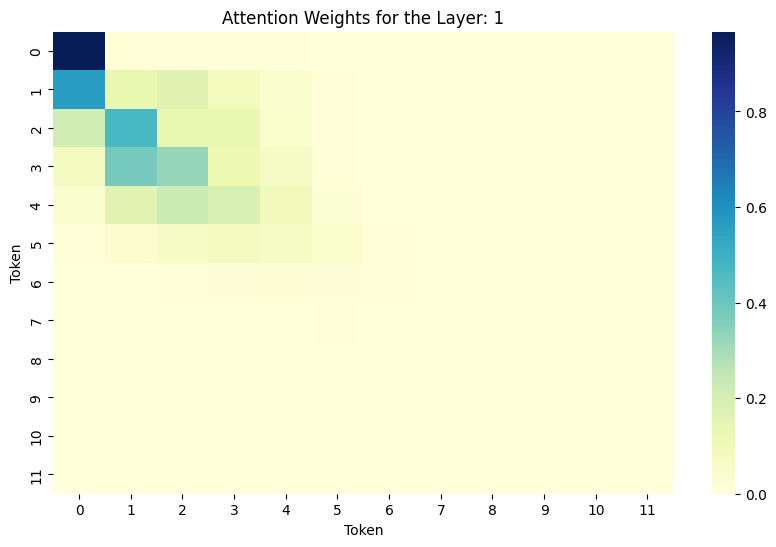

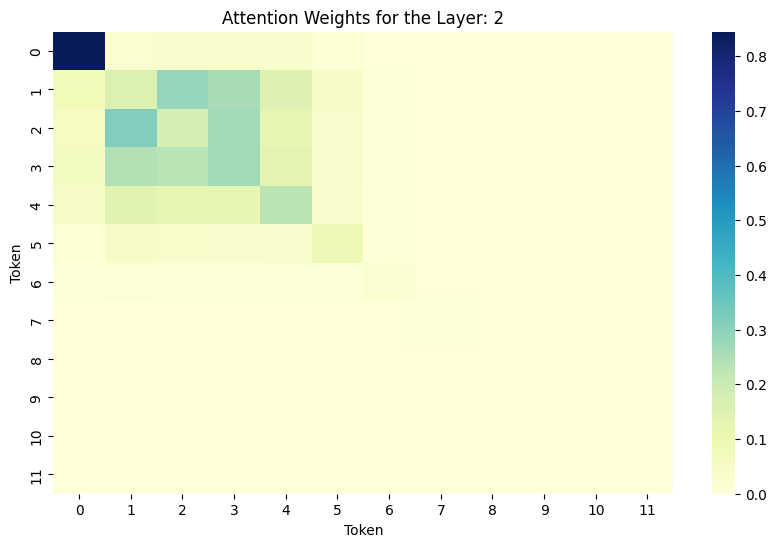

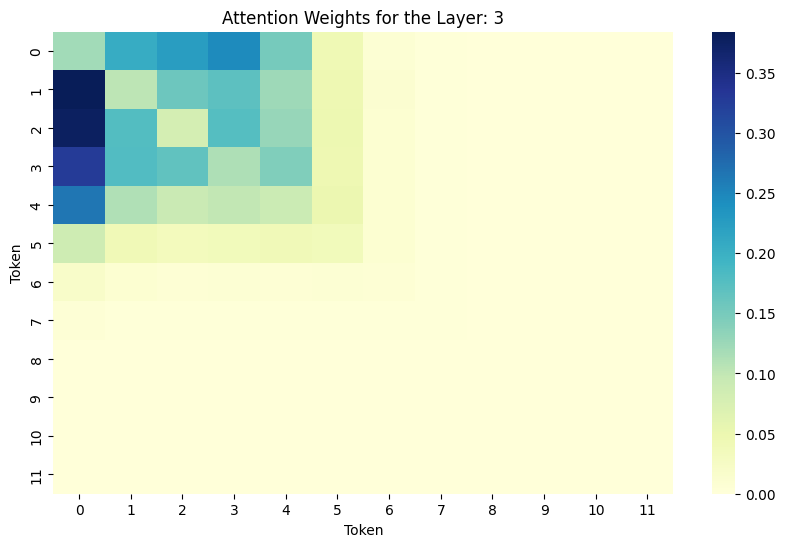

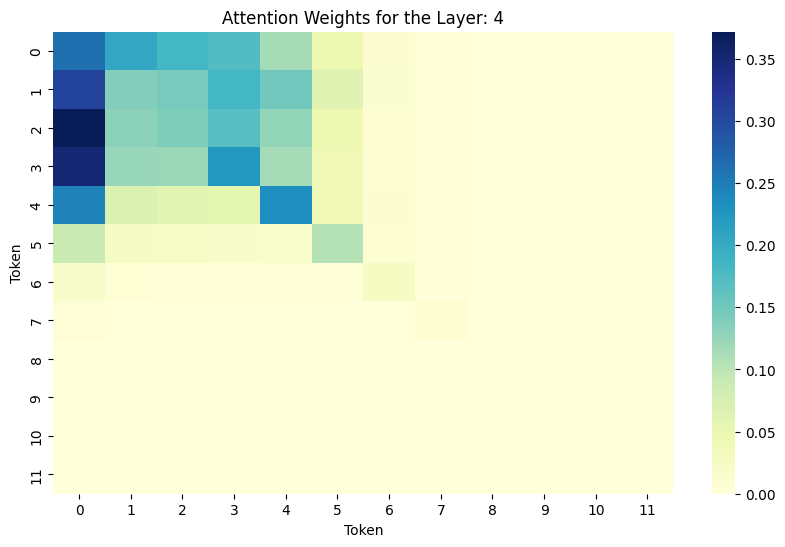

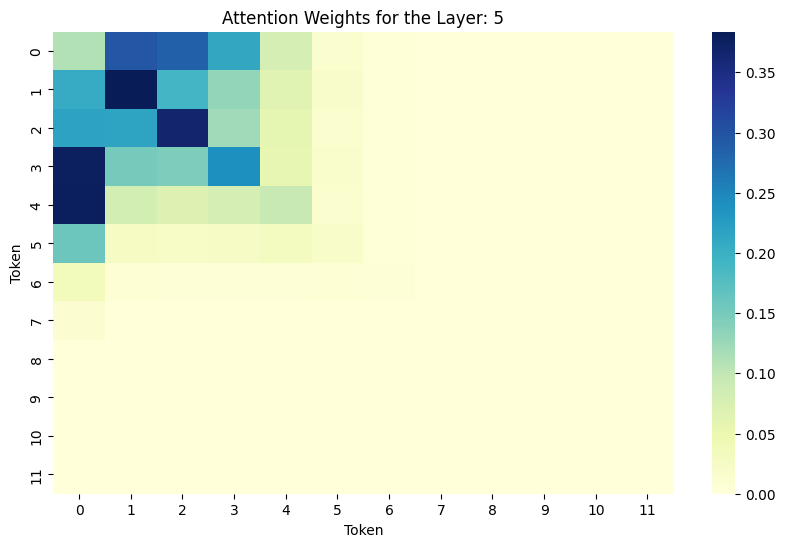

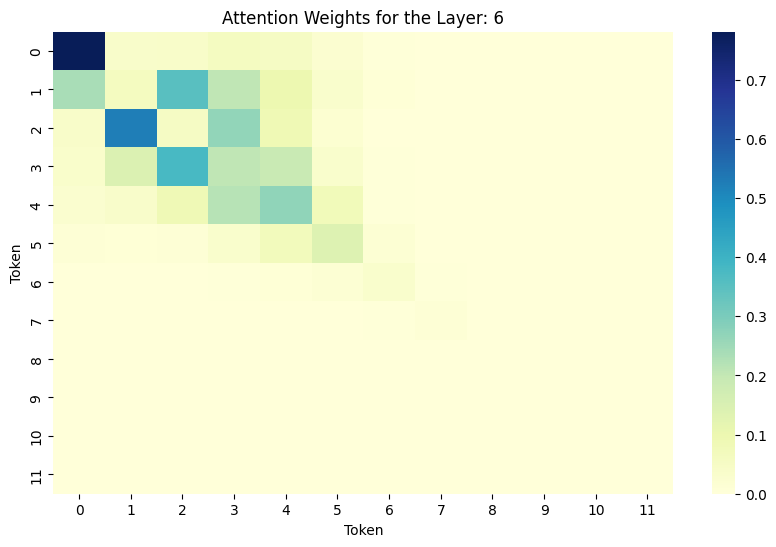

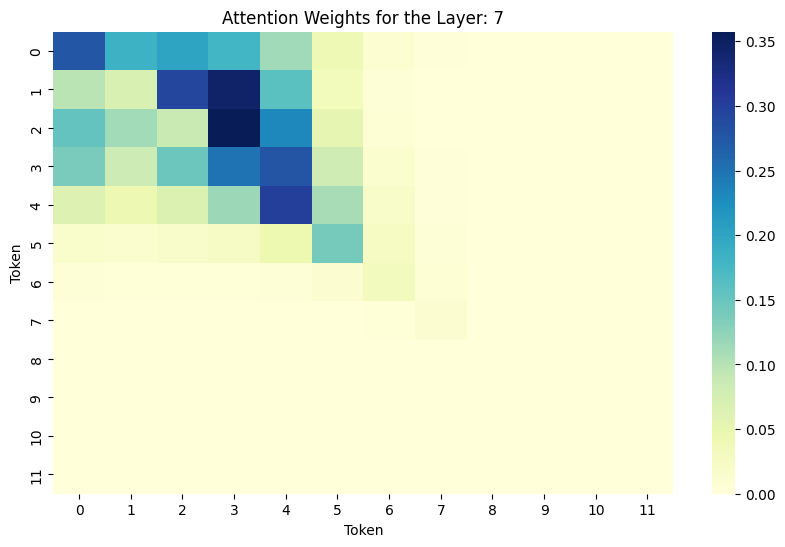

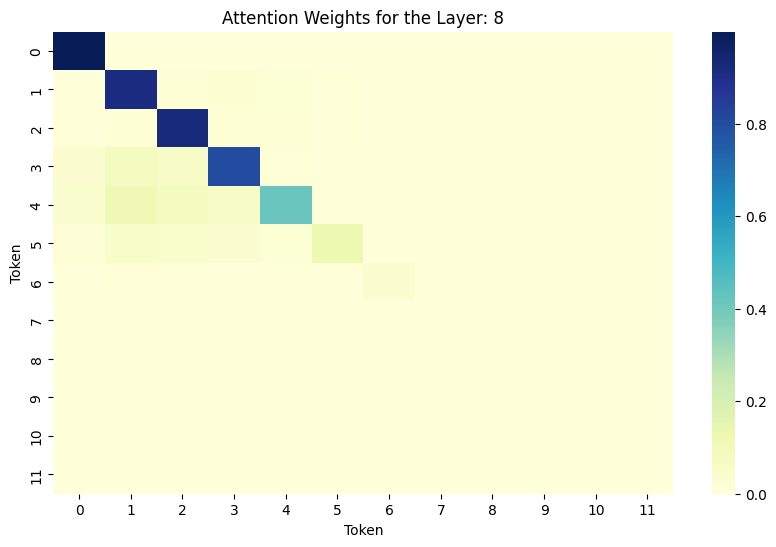

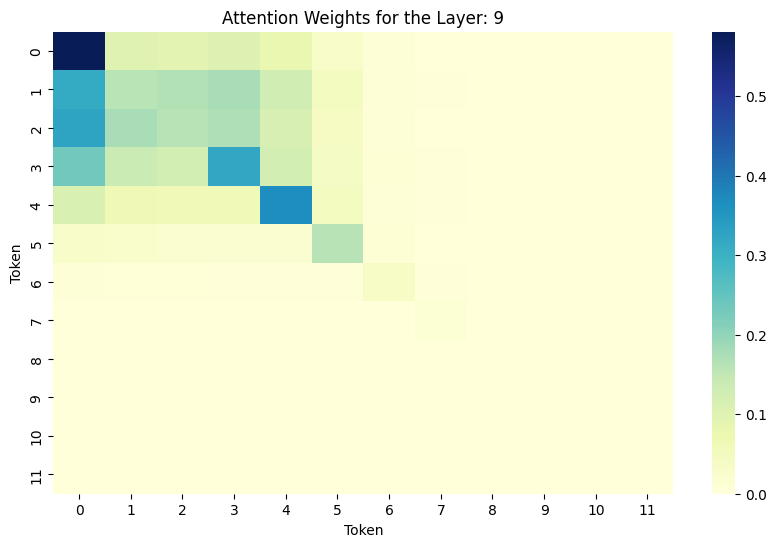

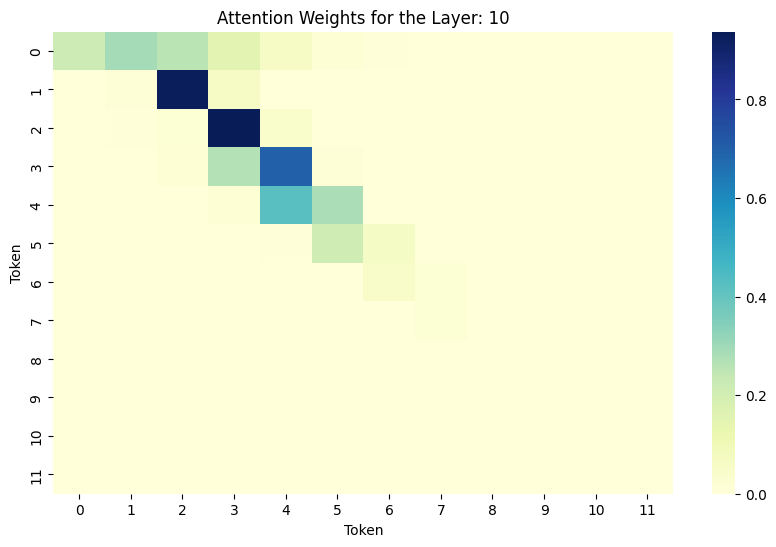

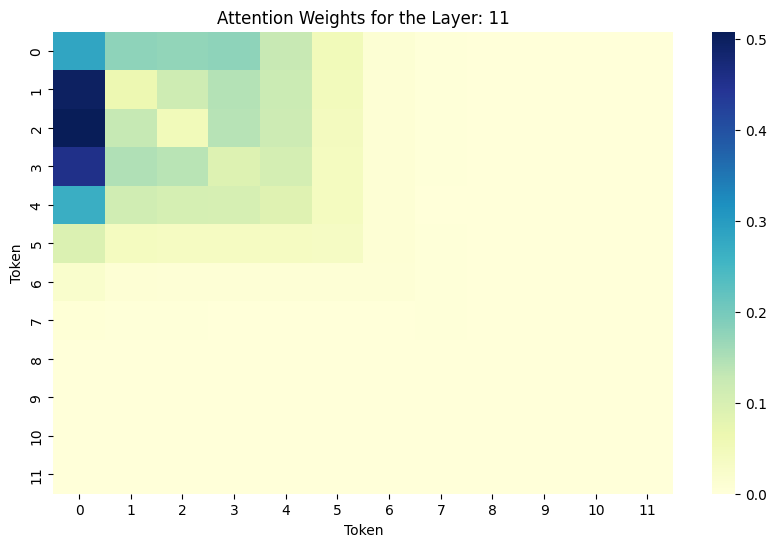

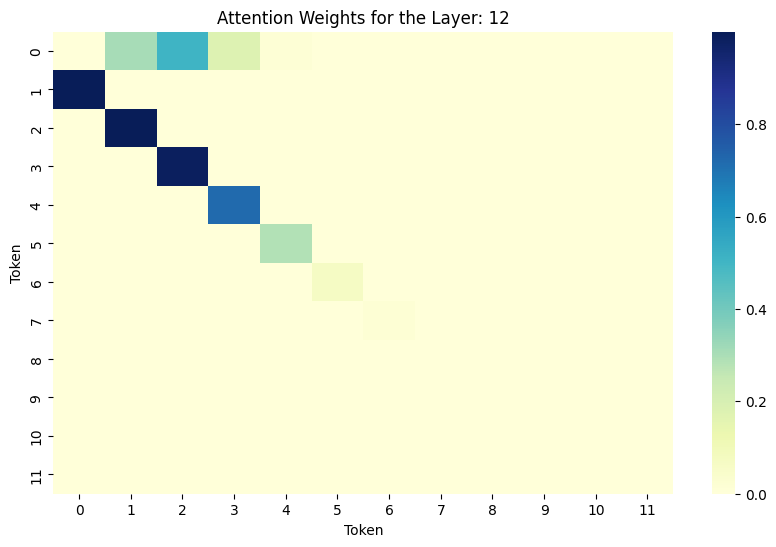

In [29]:
padded_attention_weights = []
max_size = 12

for attention_matrix in attention_weights:
    # Get the current shape of the attention matrix
    current_shape = attention_matrix.shape

    # Pad or truncate the attention matrix along the third and fourth dimensions
    pad_width = [(0, 0)] * 2  # No padding along the first two dimensions
    for i in range(2, 4):  # Pad only the third and fourth dimensions
        if current_shape[i] < max_size:
            pad_width.append((0, max_size - current_shape[i]))
        elif current_shape[i] > max_size:
            pad_width.append((0, max_size))
        else:
            pad_width.append((0, 0))

    # Pad the attention matrix
    padded_attention_matrix = np.pad(attention_matrix, pad_width, mode='constant', constant_values=0)

    # Append the padded attention matrix to the list
    padded_attention_weights.append(padded_attention_matrix)
# Plot heatmap for attention weights of the first layer
import seaborn as sns
import matplotlib.pyplot as plt
attention_array = np.array(padded_attention_weights)
average_attention_matrices = np.mean(attention_array, axis=0)
for i in range(12):
    plt.figure(figsize=(10, 6))
    sns.heatmap(average_attention_matrices[0][i], cmap="YlGnBu")
    plt.title('Attention Weights for the Layer: '+ str(i+1))
    plt.xlabel('Token')
    plt.ylabel('Token')
    plt.show()

# Report [10]

Make a report summarizing your findings and claims

## Q1
---
The experiment was to check if the model encodes information about the first letter of a word.the model was a multiclass model that was trained to predict the first letter of a word. The model was able to predict the first letter of a word with an accuracy of 0.59. This shows that the model is somewhat able to encode information about the first letter of a word given there were 26 classes

---
## Q2
---
the experiment was to check if the model encodes information about the letters of a word by making it impossible for the semantics to be used in the above task. We replaced the words with random letters except the fist letter of each word because we learnt in Q1 that the model is able to encode information about the first letter of a word  . and we conduct the experimnet 1 of randomly changing the words to capitalized or small and obsrve the accuracies .
The lower layers of the model performed better in the experiment compared to higher layers which shows that the model is able to encode information about the letters of a word in the lower layers of the model .

---
## Q3

The hypothesis was that certain layers of the model are used to encode certain information. The lower and middle layers of the model are used to encode letter information and the top layers are used to encode word information.
also the attention given to a certain token and letter is different across layers in a input sequence .


### experiment
- The model replaced random k letters from a word by random k letters and the task was to predict the number of letters changed .
- the k value was also randomly selcted .
- We also observed this result across different layers of the model to understand which layer is used to code what information .
-
the middle layers give a accuracy score of 0.6 whereas the starting layers are last few layers are below 0.5 and the first few layers are arounf 0.55
The middle and lower layers performed better in the experiment. This shows the letter information is concentrated in the lower layers of the model .

as observed in the graph of precision , recall , f1 and accuracy the graph takes the best values at middle layers and then take a dip 

---
 - When we analyze how the model pays attention to words in a sentence (attention maps), we see that the earlier layers focus more on the beginning words. As the model processes further (later layers), it considers both the beginning and middle parts of the sentence. The ending words seem to be less important for this specific task.
 - The attention maps show a fascinating trend: early layers focus on initial tokens, likely for spelling information. As processing deepens (later layers), attention spreads across the beginning and middle of the sequence. This suggests deeper layers grasp more complex linguistic features beyond spelling, like word structure or context. Finally, reduced attention on ending tokens in later layers might imply the model has extracted enough information for classification and doesn't need to focus heavily on the final words.

#### The model's performance and attention patterns across layers support the idea that some parts (heads) within the model pay closer attention to specific words in the input. Notably, the middle layers perform best, suggesting they're crucial for capturing both spelling and meaning. This might involve considering both individual words (local information) and the overall sentence structure (global information). Overall, the results show that the transformer model learns to link spelling patterns to correct or incorrect labels. It accomplishes this by using attention mechanisms to focus on important words at different levels of detail.